In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt

# some SBML model
modelfile = '/gscratch/cheme/dalba/repos/ECFERS/models/b2.xml'

r = te.loadSBMLModel(modelfile)
# r = te.loadSBMLModel(r.getParamPromotedSBML(r.getSBML()))

# bin_model = 'model.b'
# r.saveState(bin_model)
# r.exportToSBML(modelfile[:-3]+'sbml')

parameter_values = r.getGlobalParameterValues()

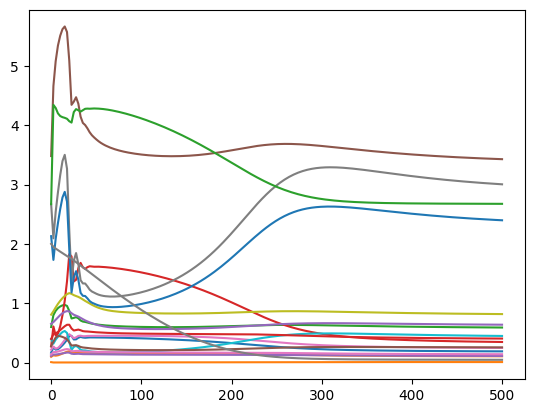

In [2]:
# new_parameter_values = parameter_values*np.random.uniform(0, 1, len(parameter_values))
# r.model.setGlobalParameterValues(parameter_values)

result = r.simulate(0, 500, 200)
r.reset()
plt.plot(result[:,0], result[:,1:])
#plt.yscale('log')

In [3]:
class SBMLGlobalFit:

    def __init__(self, model, data, parameters, settings, scale = False):
        self.model = model
        self.data = data
        self.parameters = parameters
        self.settings = settings
        self.upperb = np.array([i*10 for i in parameters])
        self.lowerb = np.array([i/10 for i in parameters])
        self.scale = scale

    def fitness(self, x):
        if self.scale: x = self._unsacale(x)
        results = self._simulate(x)
        return self._residual(results,self.data)

    def _simulate(self, x):
        from roadrunner import Config
        Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
        Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
        Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)

        r = te.loadSBMLModel(self.model)
        for i,p in enumerate(x):
            try:
                r.model.setGlobalParameterValues([i], [p])
            except:
                pass
        # r.model.setGlobalParameterValues(x)
        
        try:
            results = r.simulate(**self.settings['simulation'])[:,1:].__array__()
        except:
            results = self.data*(-np.inf)
        return results
    # def _residual(self,results,data,points):
    #     md = (np.nanmax(data,1,keepdims=True)-np.nanmin(data,1,keepdims=True))/2
    #     mr = (np.nanmax(results,1,keepdims=True)-np.nanmin(results,1,keepdims=True))/2
    #     denom = np.ones(data.shape)
    #     return [np.nansum(((data-results)/(points*(md**2+mr**2)**0.5*denom))**2)]

    def _residual(self,results,data):
        cols = self.settings['fit_to_cols']
        rows = self.settings['fit_to_rows']

        error = (data[:,cols][rows,:]-results[:,cols][rows,:])
        RMSE = np.sqrt(np.sum(error**2, axis=0)/len(rows))
        NRMSE = RMSE/(np.max(data[:,cols][rows,:], axis=0) - np.min(data[:,cols][rows,:], axis=0))
        return [np.sum(NRMSE)]
    
    def _unscale(self, x):
        return self.lowerb + (self.upperb - self.lowerb) * x
    
    def _scale(self, x):
        return (x - self.lowerb) / (self.upperb - self.lowerb)

    def get_bounds(self):
        if self.scale:
            lowerb = [0 for i in self.lowerb]
            upperb = [1 for i in self.upperb]
        else:
            upperb = self.upperb
            lowerb = self.lowerb    
        return (lowerb, upperb)
    
    def get_name(self):
        return 'Global Fitting of Multiple SBML Models'

    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x),x)


In [4]:
# pick a number of data points to fit to
settings = {'fit_to_cols':list(np.random.choice(r.getNumFloatingSpecies(),(r.getNumFloatingSpecies()//1),replace=False))}
settings['fit_to_rows'] = list(map(int, np.linspace(0,199-1,10)))
settings['simulation'] = {'start':0, 'end':500, 'points':200}

myprob = SBMLGlobalFit(model = modelfile, data = result[:,1:].__array__(), parameters=parameter_values, settings=settings, scale=True)
prob = pg.problem(myprob)

In [22]:
prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__())

[3.9023194815188225]

In [6]:
udbfe = pg.ipyparallel_bfe()
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'})
mybfe = pg.bfe(udbfe)

# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.01, variant=5, neighb_type=2, neighb_param=4)
a.set_bfe(mybfe)
algo = pg.algorithm(a)
algo.set_verbosity(1)
pops = [pg.population(prob, size = 0) for _ in range(5)];

In [183]:
total_nodes = 40*18
init_std = 0.17

for p in pops:
    xs = (np.expand_dims(myprob._scale(parameter_values),-1)@np.ones((1,total_nodes))*(1+np.random.normal(0, init_std,(len(parameter_values),total_nodes)))).T + 0.1
    fs = udbfe._view.map_sync(myprob.fitness,xs)
    list(map(p.push_back, xs, fs))

In [12]:
import pickle

# with open('results.dat', 'rb') as file:
#     res = pickle.load(file)

with open('checkpoint.dat', 'rb') as file:
    pops = pickle.load(file)

In [13]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
res = []
for i in range(100):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [algo.evolve(p) for p in pops]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))
    res.append(np.array(algo.extract(pg.pso_gen).get_log()))

    with open('results.dat', 'wb') as file:
        pickle.dump(res, file)

    with open('checkpoint.dat', 'wb') as file:
        pickle.dump(pops, file)

    if np.min([p.champion_f for p in pops]) < 1:
        break
    
results = np.concatenate(res,axis=1)

14-02-2024, 18:39:29 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            720        8.89011     0.00471366        13.5052       0.924695
      2           1440        8.89011     0.00339698        13.5007       0.929541
      3           2160        8.89011     0.00156551        13.4981       0.933254
      4           2880        8.89011       0.001483         13.483       0.932329
      5           3600        8.89011     0.00301976         13.428       0.927941
      6           4320        8.89011     0.00411418        13.2831       0.924743
      7           5040        8.82001     0.00409769         13.179        0.92571
      8           5760        8.82001     0.00326638        13.1557       0.930185
      9           6480        8.82001     0.00191661        13.1428       0.934974
     10           7200        8.82001      0.0013781        13.1305       0.936901
Exit condition -- generations = 10

   Gen

KeyboardInterrupt: 

In [9]:
results = np.concatenate(res,axis=1)

Text(0.5, 1.0, 'Convergence curves (n=10, independent; p=100) for fitting MAPK')

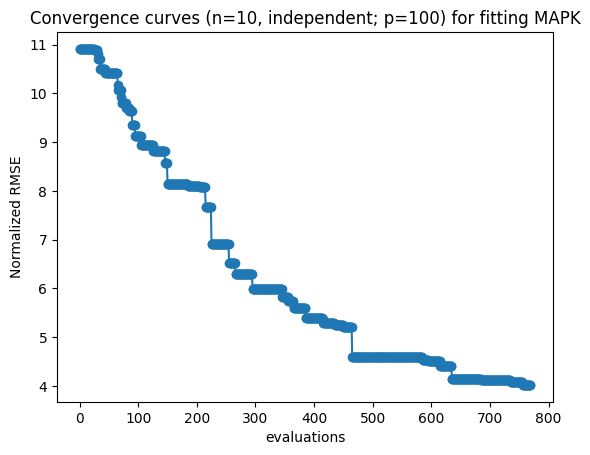

In [14]:
plt.plot(np.concatenate(res,axis=0)[:,2].T,'o-')
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Normalized RMSE')
plt.xlabel('evaluations')
plt.title('Convergence curves (n=10, independent; p=100) for fitting MAPK')  

(array([ 4.,  5., 22., 20., 17., 13., 18., 19., 13., 13.]),
 array([0.00919159, 0.04162391, 0.07405623, 0.10648854, 0.13892086,
        0.17135318, 0.2037855 , 0.23621781, 0.26865013, 0.30108245,
        0.33351477]),
 <BarContainer object of 10 artists>)

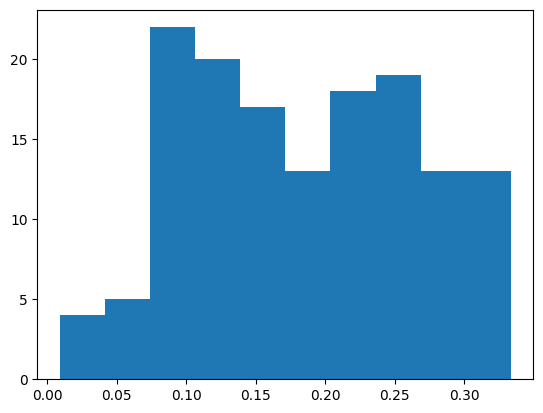

In [15]:
plt.hist(pops[0].get_x()[4,:])

Could not set value for cadp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for camp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for catp, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValues(bool (*)(rrllvm::LLVMModelData*, int, double), rrllvm::LLVMExecutableModel::GetNameFuncPtr, size_t, const int*, const double*, bool)
Could not set value for cnad, as it is defined by an assignment rule, and can not be set independently., at int rrllvm::LLVMExecutableModel::setValu

(-0.2811024511151514, 5.94649432923366)

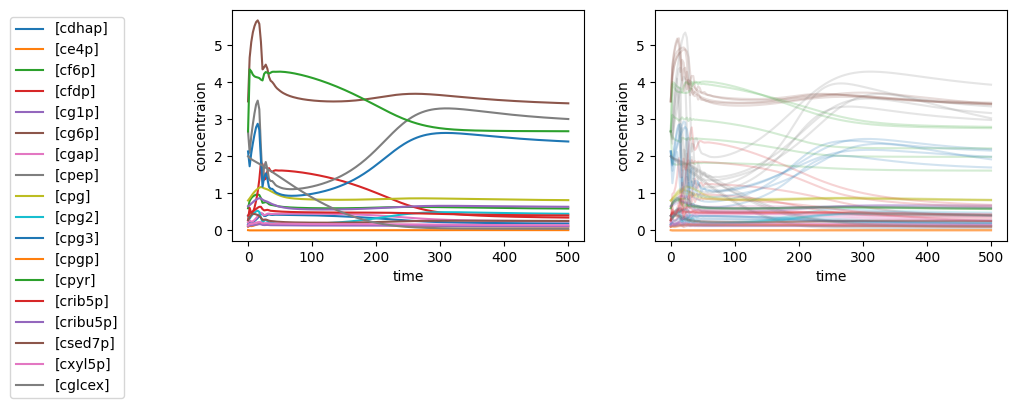

In [17]:
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
plt.figure(figsize=(10,3))
a = plt.subplot(1,2,1)
a.plot(result['time'],result[:,1:].__array__())
a.legend(result.colnames[1:], bbox_to_anchor=(-0.65, 1), loc='upper left' )
a.set_xlabel('time')
a.set_ylabel('concentraion')
#a.set_yscale('log')

b = plt.subplot(1,2,2)
mean_result = result*0
for k,c in enumerate([p.champion_x for p in pops]):
    r.resetToOrigin()
    for i,p in enumerate(myprob._unscale(c)):
        try:
            r.model.setGlobalParameterValues([i], [p])
        except Exception as e:
            print(e)
            pass
    try:
        result2 = r.simulate(**settings['simulation'])
    except Exception as e:
        print(k)
        print(e)
        result2 = result*0
    mean_result += result2
    
    b.set_prop_cycle(color=colors)
    b.plot(result['time'], result2[:,1:].__array__(), alpha = 0.2)

b.set_prop_cycle(color=colors)
#b.plot(result['time'][settings['fit_to_rows']], (mean_result[:,1:].__array__()/8)[:,settings['fit_to_cols']][settings['fit_to_rows'],:],'o')
b.set_xlabel('time')
b.set_ylabel('concentraion')
#b.set_yscale('log')
b.set_ylim(a.get_ylim())